### ΟΡΑΣΗ ΥΠΟΛΟΓΙΣΤΩΝ  1ο ΕΡΓΑΣΤΗΡΙΟ

##### Παυλάκη Βούλα ΑΜ: 03117190
##### Τσακανίκα Χριστίνα ΑΜ: 03117012

### Θέμα: Εντοπισμός Σημείων Ενδιαφέροντος και Εξαγωγή Χαρακτηριστικών σε Εικόνες

#### Μέρος 1: Ανίχνευση Ακμών σε Γκρίζες Εικόνες


In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math 
%matplotlib inline

#### 1.1. Δημιουργία Εικόνων Εισόδου

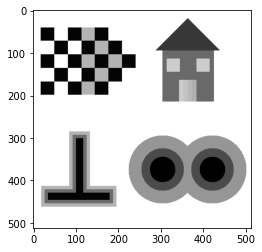

In [2]:
#1.1.1 Read grayscale image
Io = cv2.imread('edgetest_10.png',cv2.IMREAD_GRAYSCALE)

#print("Resolution: ", str(Io.shape[0]), 'x',str(Io.shape[1]))
#print("Range: %d - %d " % (Io.min(), Io.max()))

# Normalize to [0,1]
Io = Io.astype(np.float)/Io.max()

#Show image
plt.imshow(Io, cmap='gray')

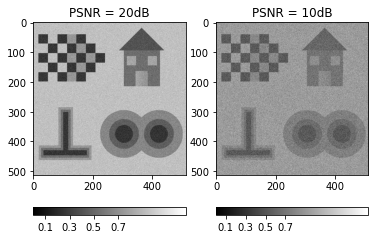

In [3]:
#1.1.2 Add noise
#img --> numpy.ndarray, shape 512 x 512
row,col= Io.shape
mean = 0
sigma1 = (Io.max() - Io.min())/10 #PSNR = 20dB
sigma2 = (Io.max() - Io.min())/np.sqrt(10) #PSNR = 10dB

gauss1 = np.random.normal(mean,sigma1,(row,col))
gauss2 = np.random.normal(mean,sigma2,(row,col))

I1 = Io + gauss1
I2 = Io + gauss2

Imin1 = I1.min()
Imax1 = I1.max()

Imin2 = I2.min()
Imax2 = I2.max()

#convert I into binary
I1 = I1 - I1.min()
I1 = I1.astype(np.float)/Imax1

I2 = I2 - I2.min()
I2 = I2.astype(np.float)/Imax2

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)

imgplot = plt.imshow(I1,cmap='gray')
ax.set_title('PSNR = 20dB')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
ax = fig.add_subplot(1, 2, 2)

imgplot = plt.imshow(I2,cmap='gray')
ax.set_title('PSNR = 10dB')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

#### 1.2. Υλοποίηση Αλγορίθμων Ανίχνευσης Ακμών

In [4]:
#the Image that enters in EdgeDetect should be binary!

def EdgeDetect(Image, sd, theta_edge, approximation):
    n = int(2*np.ceil(3*sd)+1)
    #1.2.1 i
    gauss1D = cv2.getGaussianKernel(n, sd) # Column vector
    gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    
    #ii
    ax = np.linspace(-n/2, n/2, n)
    
    xx, yy = np.meshgrid(ax, ax)
    
    kernel = ((-1)/(np.pi*sd**4))*((1-(xx**2+yy**2)/(2*sd**2)))* np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sd))
    h = kernel 
    
    #1.2.2
    #smoothed image Is
    Is = cv2.filter2D(Image,-1,gauss2D)
    
    plt.imshow(Is,cmap='gray')
    plt.title('Smoothed Image Is:')
    plt.show()
    
    B =  np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
    
    eroded = cv2.erode(Is,B)
    
    plt.imshow(Is,cmap='gray')
    plt.title('Eroded Image:')
    plt.show()
    
    dilated = cv2.dilate(Is, B)
    
    plt.imshow(Is,cmap='gray')
    plt.title('Dilated Image:')
    plt.show()
    #i
    if approximation == 'linear':
        L = cv2.filter2D(Image,-1,h)
        
        plt.imshow(L,cmap='gray')
        plt.title('LoG Filter:')
        plt.show()
    #1.2.2 ii
    if approximation == 'non linear':
        L = cv2.dilate(Is,B) + cv2.erode(Is, B) - 2*Is
        plt.imshow(L,cmap='gray')
        plt.title('Non Linear Filter:')
        plt.show()
    
    #1.2.3
    #a
    _,X = cv2.threshold(L, 0, 1, cv2.THRESH_BINARY)
    plt.imshow(X,cmap='gray')
    plt.title('Thresholded Image:')
    plt.show()
    #b
    Y = cv2.dilate(X,B) - cv2.erode(X, B)
    
    #1.2.4

    gradIs = np.gradient(Is)
    gradX = gradIs[0]
    gradY = gradIs[1]
   
    grad = np.sqrt(gradX**2 + gradY**2)
    temp = np.zeros_like(grad)
    temp = (grad > theta_edge*np.amax(grad)).astype(np.uint8)
    D = Y*temp
    
    plt.imshow(D,cmap='gray')
    plt.title('Edge Detect Image:')
    plt.show()

    return D

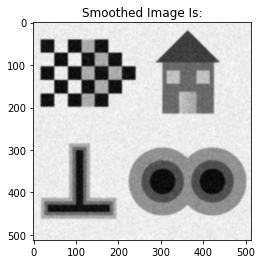

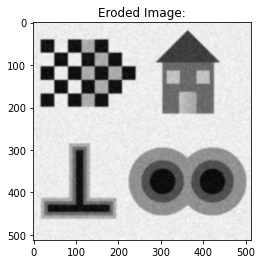

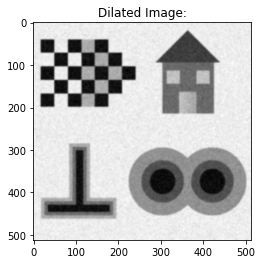

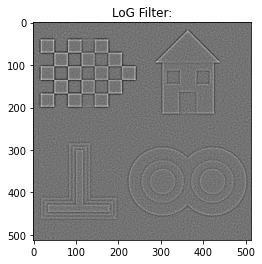

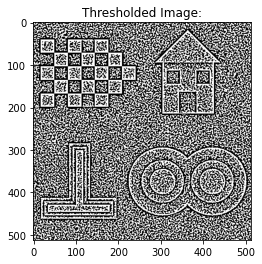

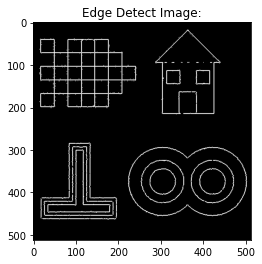

In [5]:
D = EdgeDetect(I1, 1.5, 0.2, 'linear')

#### 1.3. Αξιολόγηση των Αποτελεσμάτων Ανίχνευσης Ακμών

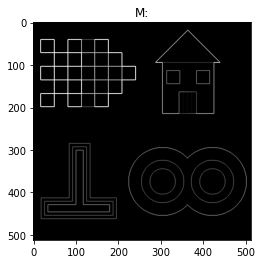

Text(0.5, 1.0, 'T computed with real edge = 0.009:')

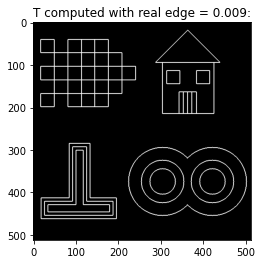

In [10]:
#1.3.1
B =  np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
M = cv2.dilate(Io,B) - cv2.erode(Io, B)
plt.imshow(M, cmap='gray')
plt.title('M:')
plt.show()

#real_edge = 0.009 
_,T = cv2.threshold(M, 0.009, 1, cv2.THRESH_BINARY)
plt.imshow(T, cmap='gray')
plt.title('T computed with real edge = 0.009:')

In [11]:
#1.3.2
def ComputePrecision(D,T):
    #Firstly, we compute P(D and T) = P(T and D)
    commons = 0 #we compute the number of the common ones of the array
    for i in range(len(D)):
        for j in range(len(D[i])):
            if D[i][j] == T[i][j] and D[i][j]==1:
                commons +=1
    card_T = T.sum()
    card_D = D.sum()
    C = ((commons/card_T) + (commons/card_D))/2
    return C

In [12]:
#Here D image had parameters PSNR = 20db, s = 1.5, theta_edge=0.2 and linear approximation
ComputePrecision(D,T)

0.9226477298715285

20dB and linear:


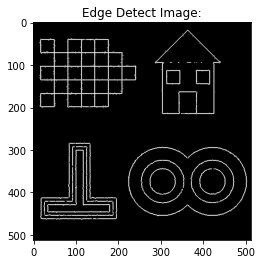

20dB and non linear:


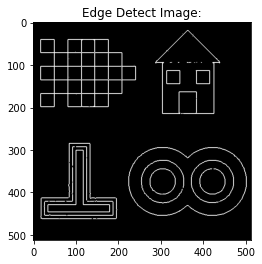

10dB and linear:


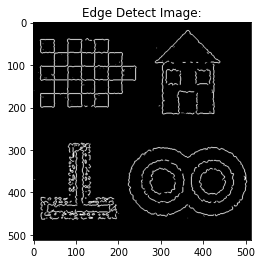

10dB and non linear:


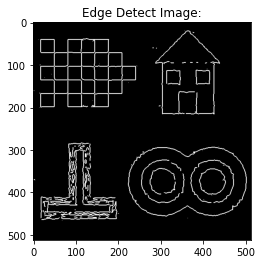

In [13]:
#1.3.3
print('20dB and linear:')
linear20 = EdgeDetect(I1,1.5,0.2,'linear')
print('20dB and non linear:')
nonlinear20 = EdgeDetect(I1,1.5,0.2,'non linear')
print('10dB and linear:')
linear10 = EdgeDetect(I2,3,0.2,'linear')
print('10dB and non linear:')
nonlinear10 = EdgeDetect(I2,3,0.2,'non linear')

In [14]:
#1.3.3
print('20dB and linear:', ComputePrecision(linear20,T))
print('20dB and non linear:', ComputePrecision(nonlinear20,T))
print('10dB and linear:', ComputePrecision(linear10,T))
print('10dB and non linear:',ComputePrecision(nonlinear10,T))

20dB and linear: 0.9226477298715285
20dB and non linear: 0.9554657962694699
10dB and linear: 0.606286229767032
10dB and non linear: 0.7385686451888926


Πειραματιζόμενοι με τις παραμέτρους σ, θegde, καταλήξαμε στις βέλτιστες τιμές παραμέτρων (αποδίδονται ως σχόλια στο παρακάτω cell).
To οπτικό αποτέλεσμα είναι το ακόλουθο:

20dB and linear:


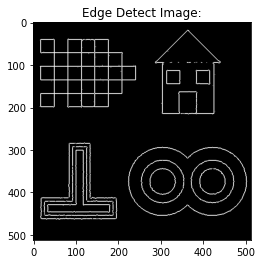

20dB and non linear:


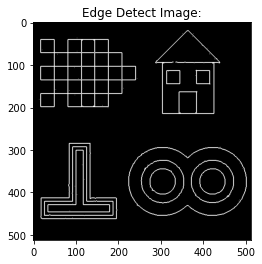

10dB and linear:


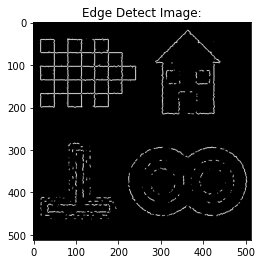

10dB and non linear:


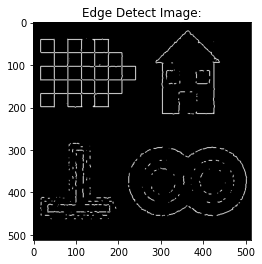

In [15]:
print('20dB and linear:')
linear20 = EdgeDetect(I1,1.7,0.2,'linear') #σ=1.7, theta_edge=0.2 #max EdgeDetect(I1,1.7,0.2,'linear') η μειωση της γωνιας ελαττωνει ελαχιστα την αποδοση
print('20dB and non linear:')
nonlinear20 = EdgeDetect(I1,1.7,0.14,'non linear') #σ=1.7, theta_edge=0.16 #max EdgeDetect(I1,1.7,0.2,'non linear') ξ μειωση της γωνιας αυξανει ελάχιστα την επιδοση
print('10dB and linear:')
linear10 = EdgeDetect(I2,2,0.3,'linear') #σ=2, theta_edge=0.3 #max for EdgeDetect(I2,2,0.3,'linear') 0.6664276400139927
print('10dB and non linear:')
nonlinear10 = EdgeDetect(I2,2,0.3,'non linear') #σ=2, theta_edge=0.3

In [16]:
print('20dB and linear:', ComputePrecision(linear20,T))
print('20dB and non linear:', ComputePrecision(nonlinear20,T))
print('10dB and linear:', ComputePrecision(linear10,T))
print('10dB and non linear:',ComputePrecision(nonlinear10,T))

20dB and linear: 0.9290829621538936
20dB and non linear: 0.9602364055978865
10dB and linear: 0.6743185104479421
10dB and non linear: 0.7251463391229249


#### 1.4. Εφαρμογή των Αλγορίθμων Ανίχνευσης Ακμών σε Πραγματικές εικόνες

Text(0.5, 1.0, 'Our image is:')

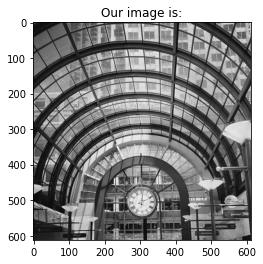

In [17]:
#1.4
# Read colored image
img = cv2.imread('urban_edges.jpg')
# Convert from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert from rgb to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Convert to float and scale from 0 to 1
img_gray = img_gray.astype(np.float)/img_gray.max()

#Show image
plt.imshow(img_gray, cmap='gray')
plt.title('Our image is:')

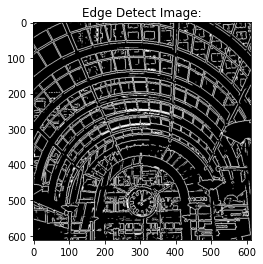

In [18]:
#1.4.1 Edge Detect algorithm to image without noise
D = EdgeDetect(img_gray, 1.5, 0.2, 'linear')

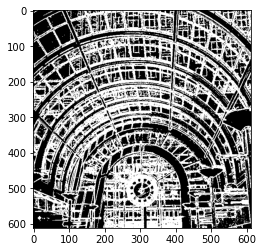

In [19]:
M = cv2.dilate(img_gray,B) - cv2.erode(img_gray, B)

_,T = cv2.threshold(M, 0.08588, 1, cv2.THRESH_BINARY)
plt.imshow(T, cmap='gray') 

In [20]:
ComputePrecision(D,T)

0.6794706602910972

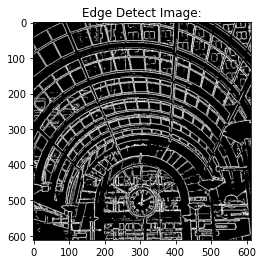

0.7047092724274033


In [17]:
#1.3.3
D1 = EdgeDetect(img_gray, 0.797, 0.2, 'linear')#best
print(ComputePrecision(D1,T))

#### Μέρος 2: Ανίχνευση Σημείων Ενδιαφέροντος (Interest Point Detection)


In [21]:
#part2
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from cv21_lab1_part2_utils import interest_points_visualization
from cv21_lab1_part2_utils import disk_strel

#### 2.1. Ανίχνευση Γωνιών


In [22]:
def CornerDetection(Image, sd, p, theta_corn,k):   #Harris-Stephens Method
    
    #image = cv2.imread('urban_edges.jpg',cv2.IMREAD_GRAYSCALE)  
    image = Image.astype(np.float)/Image.max()
    
    ns = int(np.ceil(3*sd)*2+1)
    gauss1D = cv2.getGaussianKernel(ns, sd) # Column vector
    Gs = gauss1D @ gauss1D.T # Symmetric gaussian kernel

    gauss1D = cv2.getGaussianKernel(ns, p) # Column vector
    Gp = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    
    Is = cv2.filter2D(image,-1,Gs)
    gradIs = np.gradient(Is)
    
    gradX = gradIs[0] #dIs/dx
    gradY = gradIs[1] #dIs/dy

    prod1 = np.multiply(gradX, gradX)
    prod2 = np.multiply(gradX, gradY)
    prod3 = np.multiply(gradY, gradY)
    
    #[gradX,gradY]=np.gradient(Is)
    #prod1 = gradX * gradX 
    #prod2 = gradX * gradY
    #prod3 = gradY * gradY
    
    #2.1.1
    J1 = cv2.filter2D(prod1,-1,Gp)
    J2 = cv2.filter2D(prod2,-1,Gp)
    J3 = cv2.filter2D(prod3,-1,Gp)

    #2.1.2
    ev1 = 1/2 * (J1+J3+np.sqrt(np.square(J1-J3)+np.square(2*J2)))
    ev2 = 1/2 * (J1+J3-np.sqrt(np.square(J1-J3)+np.square(2*J2)))

    #ev1 = (J1+J3+np.sqrt((J1-J3)**2+4*J2**2))/2
    #ev2 = (J1+J3-np.sqrt((J1-J3)**2+4*J2**2))/2

    
    #R = np.matmul(ev1,ev2) - k*np.square(ev1+ev2)
    R = ev1*ev2 - k*np.square(ev1+ev2)

    map(max, R)
    list(map(max, R))
    
    #2.1.3
    Rmax = max(map(max, R))
    
    B_sq = disk_strel(ns)
    
    corners=[]
    
    dilation = cv2.dilate(R,B_sq)
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j]==dilation[i][j] and R[i][j] > theta_corn*Rmax:
                corners.append([j,i,sd])
    return np.array(corners)
    
    #return np.array(kp_data)


<AxesSubplot:>

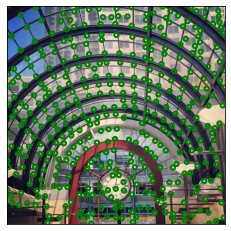

In [23]:
#visualise corner points
img = cv2.imread('urban_edges.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

image = cv2.imread('urban_edges.jpg',cv2.IMREAD_GRAYSCALE)
photo = CornerDetection(image, 2, 2.5,0.005, 0.05)
#plt.imshow(photo, cmap='gray_r') 

interest_points_visualization(img, photo, None)

#### 2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών

In [24]:
#2.2
def HarrisLaplacian(I,sd,N,s,p,theta_corn,k):

    #Lxx = d/dx(dIs/dx) & Lyy = d/dy(dIs/dy)
    Is_total = []
    Isxx = []
    Isyy = []
    total_edges =[]
    LoG = []
    for i in range(N):

        ns = int(np.ceil(3*((s**i)*sd))*2+1)
        gauss1D = cv2.getGaussianKernel(ns, (s**i)*sd) # Column vector
        Gs = gauss1D @ gauss1D.T # Symmetric gaussian kernel
        
        img_gray = I.astype(np.float)/I.max()
        
        Is = cv2.filter2D(img_gray,-1,Gs)
        
        Is_total.append(Is)
        gradIs = np.gradient(Is)
        temp1 = np.gradient(gradIs[0])
        temp2 = np.gradient(gradIs[1])

        Isxx = temp1[0]
        Isyy = temp2[1]
        
        LoG.append(((s**i)*sd)**2*abs(Isxx + Isyy))

        photo = CornerDetection(I, (s**i)*sd, (s**i)*p, theta_corn,k)
        total_edges.append(photo)
    
    i = -1
    edges =[]
    for arr in total_edges:
        i+=1
        for lis in arr: #lis: [269. 308.   2.]
            #if the curr LoG value is the max from prev and next, we keep the point
            curr = LoG[i][int(lis[1])][int(lis[0])]
                
            if i == 0:
                next = LoG[i+1][int(lis[1])][int(lis[0])]
                #prev = LoG[N-1][int(lis[0])][int(lis[1])]
                prev = next-1 #pseudovalue
            elif i == N-1:
                #next =  LoG[0][int(lis[0])][int(lis[1])]
                prev = LoG[i-1][int(lis[1])][int(lis[0])]
                next = prev-1 #pseudovalue
            else:
                next =  LoG[i+1][int(lis[1])][int(lis[0])]
                previous = LoG[i-1][int(lis[1])][int(lis[0])]
                
            if (curr > prev) and (curr > next):
                edges.append([lis[0],lis[1],lis[2]])
                
    #interest_points_visualization(img, edges, None)
    return np.array(edges)
    

<AxesSubplot:>

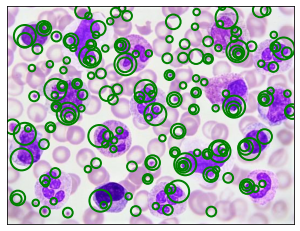

In [25]:
img_gray = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
edges = HarrisLaplacian(img_gray,2,4,1.5,2.5,0.005,0.05)

img = cv2.imread('blood_smear.jpg')
bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
interest_points_visualization(bgr_img, edges, None)

<AxesSubplot:>

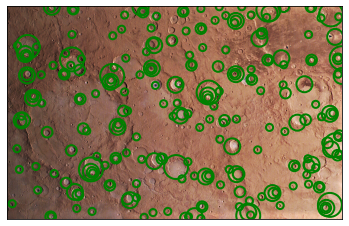

In [26]:
img_gray = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
edges = HarrisLaplacian(img_gray,2,4,1.5,2.5,0.005,0.05)

img = cv2.imread('mars.png')
bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
interest_points_visualization(bgr_img, edges, None)

#### 2.3. Ανίχνευση Blobs


In [27]:
#2.3
def Blobs(I, sd, theta_corn,k):
    
    #img = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = I.astype(np.float)/I.max()
    
    ns = int(np.ceil(3*sd)*2+1)
    gauss1D = cv2.getGaussianKernel(ns, sd) # Column vector
    Gs = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    
    Is_total=[]
    Is = cv2.filter2D(I,-1,Gs)
    Is_total.append(Is)
    gradIs = np.gradient(Is)
    temp1 = np.gradient(gradIs[0])
    temp2 = np.gradient(gradIs[1])

    Isxx = temp1[0]
    Isxy = temp1[1]
    Isyy = temp2[1]
    Isyx = temp2[0]
    
    R = np.abs(Isxx*Isyy -Isyx*Isxy)
    
    Rmax = max(map(max, R))
    B_sq = disk_strel(ns)
        
    corners=[]
    dilation = cv2.dilate(R,B_sq)
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j]==dilation[i][j] and R[i][j] > theta_corn*Rmax:
                corners.append([j,i,sd])
    return np.array(corners)


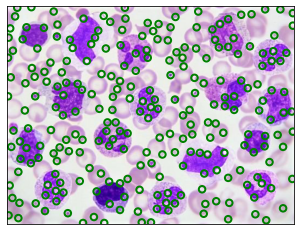

In [25]:
img = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
blobs = Blobs(img, 2,0.005,0.05)

img = cv2.imread('blood_smear.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
vis = interest_points_visualization(img, blobs, None)  

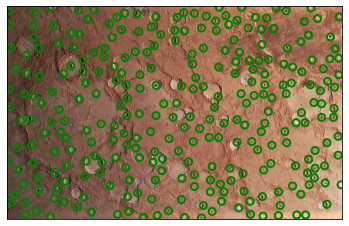

In [26]:
img = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
blobs = Blobs(img, 2,0.005,0.05)

img = cv2.imread('mars.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
vis = interest_points_visualization(img, blobs, None)  

#### 2.4. Πολυκλιμακωτή Ανίχνευση Blobs

In [28]:
def MultiscaleBlobs(I,sd,N,s,theta_corn,k):

    #Lxx = d/dx(dIs/dx) & Lyy = d/dy(dIs/dy)
    Is_total = []
    Isxx = []
    Isyy = []
    total_edges =[]
    LoG = []
    
    I1 = I.astype(np.float)/I.max()
    
    for i in range(N):

        ns = int(np.ceil(3*((s**i)*sd))*2+1)
        gauss1D = cv2.getGaussianKernel(ns, (s**i)*sd) # Column vector
        Gs = gauss1D @ gauss1D.T # Symmetric gaussian kernel

        Is = cv2.filter2D(I1,-1,Gs)
        Is_total.append(Is)
        gradIs = np.gradient(Is)
        temp1 = np.gradient(gradIs[0])
        temp2 = np.gradient(gradIs[1])

        Isxx = temp1[0]
        Isyy = temp2[1]
        
        LoG.append(((s**i)*sd)**2*abs(Isxx + Isyy))
        
        #Blobs(img, 2,0.005,0.05)
        photo = Blobs(I, (s**i)*sd, theta_corn,k)
        total_edges.append(photo)
    
    i = -1
    edges =[]
    for arr in total_edges:
        i+=1
        for lis in arr: #lis: [269. 308.   2.]
            #if the curr LoG value is the max from prev and next, we keep the point
            curr = LoG[i][int(lis[1])][int(lis[0])]
                
            if i == 0:
                next = LoG[i+1][int(lis[1])][int(lis[0])]
                prev = next-1 #pseudovalue
                
            elif i == N-1:
                prev = LoG[i-1][int(lis[1])][int(lis[0])]
                next =  prev-1 #pseudovalue
            else:
                next =  LoG[i+1][int(lis[1])][int(lis[0])]
                previous = LoG[i-1][int(lis[1])][int(lis[0])]
                
            if (curr > prev) and (curr > next):
                edges.append([lis[0],lis[1],lis[2]])
    return np.array(edges)

<AxesSubplot:>

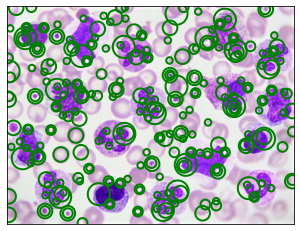

In [28]:
Image = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
edges = MultiscaleBlobs(Image,2,4,1.5,0.005,0.05)

I = cv2.imread('blood_smear.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, edges, None)

<AxesSubplot:>

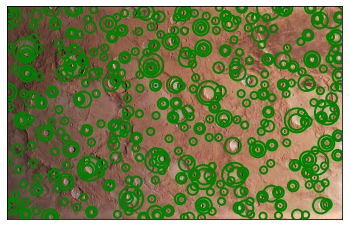

In [29]:
Image = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
edges = MultiscaleBlobs(Image,2,4,1.5,0.005,0.05)

I = cv2.imread('mars.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, edges, None)

#### 2.5. Επιτάχυνση με την χρήση Box Filters και Ολοκληρωτικών Εικόνων (Integral Images)


In [29]:
def BoxFilters(img,sd,theta_corn):
    
    theta_corn = 0.005

    img = img.astype(np.float)/img.max()

    row = img.shape[0]
    col = img.shape[1]

    #integral image
    sat = np.zeros((img.shape[0],img.shape[1]))

    for i in range(0,row):
        for j in range(0,col):
            if i == 0 and j==0:
                sat[i][j] = img[i][j]
            elif i == 0:
                sat[i][j] = sat[i][j-1] + img[i][j]
            elif j==0:
                sat[i][j] = sat[i-1][j] + img[i][j]
            else:
                sat[i][j] = sat[i-1][j] + sat[i][j-1] - sat[i-1][j-1] + img[i][j]

    ns = int(np.ceil(3*sd)*2+1)

    height_xx = int(4*np.floor(ns/6)+1)
    width_xx = 3*int(2*np.floor(ns/6)+1)

    up = down = (height_xx-1)//2
    left = right = (width_xx-1)//2

    padded_sat = sat
    padded_sat_xx = np.pad(padded_sat, ((up, down), (left, right)))
    padded_sat_yy = np.pad(padded_sat, ((left, right), (up, down)))
    padded_sat_xy = np.pad(padded_sat, ((width_xx//3, width_xx//3), (width_xx//3, width_xx//3)))

    Lyy = np.zeros((row,col))
    Lxx = np.zeros((row,col))
    Lxy = np.zeros((row,col))

    for i in range(row):
        for j in range(col):
            A1x = padded_sat_xx[i][j]
            B1x = padded_sat_xx[i][j+width_xx//3-1]
            C1x = padded_sat_xx[i+height_xx-1][j+width_xx//3-1]
            D1x = padded_sat_xx[i+height_xx-1][j]

            A2x = padded_sat_xx[i][j+width_xx//3]
            B2x = padded_sat_xx[i][j+2*width_xx//3-1]
            C2x = padded_sat_xx[i+height_xx-1][j+2*width_xx//3-1]
            D2x = padded_sat_xx[i+height_xx-1][j+width_xx//3]

            A3x = padded_sat_xx[i][j+2*width_xx//3]
            B3x = padded_sat_xx[i][j+width_xx-1]
            C3x = padded_sat_xx[i+height_xx-1][j+width_xx-1]
            D3x = padded_sat_xx[i+height_xx-1][j+2*width_xx//3]

            A1y = padded_sat_yy[i][j]
            B1y = padded_sat_yy[i][j+height_xx-1]
            C1y = padded_sat_yy[i+width_xx//3-1][j+height_xx-1]
            D1y = padded_sat_yy[i+width_xx//3-1][j]

            A2y = padded_sat_yy[i+width_xx//3][j]
            B2y = padded_sat_yy[i+width_xx//3][j+height_xx-1]
            C2y = padded_sat_yy[i+2*width_xx//3-1][j+height_xx-1]
            D2y = padded_sat_yy[i+2*width_xx//3-1][j]

            A3y = padded_sat_yy[i+2*width_xx//3][j]
            B3y = padded_sat_yy[i+2*width_xx//3][j+height_xx-1]
            C3y = padded_sat_yy[i+width_xx-1][j+height_xx-1]
            D3y = padded_sat_yy[i+width_xx-1][j]

            A1xy = padded_sat_xy[i][j]
            B1xy = padded_sat_xy[i][j+width_xx//3-1]
            C1xy = padded_sat_xy[i+width_xx//3-1][j+width_xx//3-1]
            D1xy = padded_sat_xy[i+width_xx//3-1][j]

            A2xy = padded_sat_xy[i+width_xx//3+1][j]
            B2xy = padded_sat_xy[i+width_xx//3+1][j+width_xx//3-1]
            C2xy = padded_sat_xy[i+2*width_xx//3][j+width_xx//3-1]
            D2xy = padded_sat_xy[i+2*width_xx//3][j]

            A3xy = padded_sat_xy[i][j+width_xx//3+1]
            B3xy = padded_sat_xy[i][j++2*width_xx//3]
            C3xy = padded_sat_xy[i+width_xx//3-1][j+2*width_xx//3]
            D3xy = padded_sat_xy[i+width_xx//3-1][j+width_xx//3+1]

            A4xy = padded_sat_xy[i+width_xx//3+1][j+width_xx//3+1]
            B4xy = padded_sat_xy[i+width_xx//3+1][j+2*width_xx//3]
            C4xy = padded_sat_xy[i+2*width_xx//3][j+2*width_xx//3]
            D4xy = padded_sat_xy[i+2*width_xx//3][j+width_xx//3+1]

            Lxx[i][j] = A1x+C1x-B1x-D1x -2*(A2x+C2x-B2x-D2x)+A3x+C3x-B3x-D3x
            Lyy[i][j] = A1y+C1y-B1y-D1y -2*(A2y+C2y-B2y-D2y)+A3y+C3y-B3y-D3y
            Lxy[i][j] = A1xy+C1xy-B1xy-D1xy -1*(A2xy+C2xy-B2xy-D2xy)-1*(A3xy+C3xy-B3xy-D3xy) + A4xy+C4xy-B4xy-D4xy

    R = Lxx*Lyy - np.power((0.9*Lxy),2)
    R = (R - R.min())/R.max()
    
    Rmax = max(map(max, R))
    B_sq = disk_strel(ns)
        
    points=[]
    dilation = cv2.dilate(R,B_sq)
    for i in range(len(R)):
        for j in range(len(R[i])):
            if  R[i][j]==dilation[i][j] and R[i][j] > theta_corn*Rmax:
                points.append([j,i,sd])

    return np.array(points)

<AxesSubplot:>

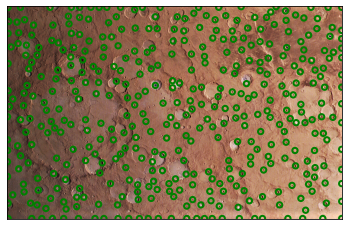

In [31]:
img = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
points = BoxFilters(img,1.5,0.005)

I = cv2.imread('mars.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, points, None)

<AxesSubplot:>

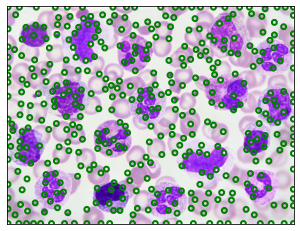

In [32]:
img = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
points = BoxFilters(img,1.5,0.005)

I = cv2.imread('blood_smear.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, points, None)

In [30]:
def MultiscaleBox(I,sd,N,s,theta_corn):
    
    Is_total = []
    Isxx = []
    Isyy = []
    total_points =[]
    LoG = []
    
    #sat = IntegralImage(I)
    for i in range(N):
        
        ns = int(np.ceil(3*((s**i)*sd))*2+1)
        gauss1D = cv2.getGaussianKernel(ns, (s**i)*sd) # Column vector
        Gs = gauss1D @ gauss1D.T # Symmetric gaussian kernel

        Is = cv2.filter2D(I,-1,Gs)
        Is_total.append(Is)
        gradIs = np.gradient(Is)
        temp1 = np.gradient(gradIs[0])
        temp2 = np.gradient(gradIs[1])

        Isxx = temp1[0]
        Isyy = temp2[1]
        
        LoG.append(((s**i)*sd)**2*abs(Isxx + Isyy))
        
        points = BoxFilters(I, (s**i)*sd, theta_corn)
        total_points.append(points)
    
    i = -1
    edges =[]
    for arr in total_points:
        i+=1
        for lis in arr: #lis: [269. 308.   2.]
            #if the curr LoG value is the max from prev and next, we keep the point
            curr = LoG[i][int(lis[1])][int(lis[0])]
                
            if i == 0:
                next = LoG[i+1][int(lis[1])][int(lis[0])]
                prev = next-1 #pseudovalue
                
            elif i == N-1:
                prev = LoG[i-1][int(lis[1])][int(lis[0])]
                next =  prev-1 #pseudovalue
            else:
                next =  LoG[i+1][int(lis[1])][int(lis[0])]
                previous = LoG[i-1][int(lis[1])][int(lis[0])]
                
            if (curr > prev) and (curr > next):
                edges.append([lis[0],lis[1],lis[2]])
    return np.array(edges)

<AxesSubplot:>

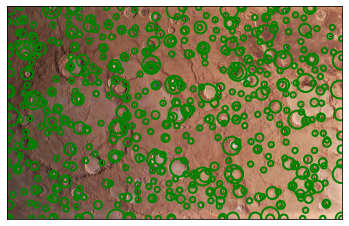

In [34]:
img = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
edges = MultiscaleBox(img,1.5,4,1.5,0.005)

I = cv2.imread('mars.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, edges, None)

<AxesSubplot:>

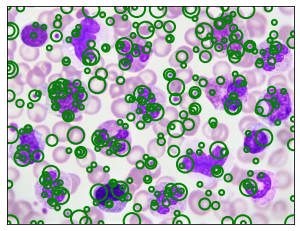

In [35]:
img = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
edges = MultiscaleBox(img,1.5,4,1.5,0.005)

I = cv2.imread('blood_smear.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)           
interest_points_visualization(I, edges, None)

In [31]:
#part3
from cv21_lab1_part3_utils import featuresSURF
from cv21_lab1_part3_utils import featuresHOG
from cv21_lab1_part3_utils import matching_evaluation
from cv21_lab1_part3_utils import createTrainTest
from cv21_lab1_part3_utils import BagOfWords
from cv21_lab1_part3_utils import svm
from cv21_lab1_part3_utils import FeatureExtraction

#### Μέρος 3: Εφαρμογές σε Ταίριασμα και Κατηγοριοποίηση Εικόνων με Χρήση Τοπικών Περιγραφητών στα Σημεία Ενδιαφέροντος

#### 3.1. Ταίριασμα Εικόνων υπό Περιστροφή και Αλλαγή Κλίμακας

In [69]:
#3.1.1
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
    
desc_fun = lambda I, kp: featuresSURF(I,kp)
    
# Execute evaluation by providing the above functions as arguments
# Returns 2 1x3 arrays containing the errors
    
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features: {:.3f}'.format(avg_theta_errors[0]))
print('\n')
print('Avg. Scale Error for Image 2 with SURF features: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features: {:.3f}'.format(avg_theta_errors[1]))
print('\n')
print('Avg. Scale Error for Image 3 with SURF features: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features: {:.3f}'.format(avg_theta_errors[2]))

Avg. Scale Error for Image 1 with SURF features: 0.007
Avg. Theta Error for Image 1 with SURF features: 1.793


Avg. Scale Error for Image 2 with SURF features: 0.002
Avg. Theta Error for Image 2 with SURF features: 0.214


Avg. Scale Error for Image 3 with SURF features: 0.005
Avg. Theta Error for Image 3 with SURF features: 0.453


In [73]:
#3.1.1
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
    
desc_fun = lambda I, kp: featuresHOG(I,kp)
    

# Execute evaluation by providing the above functions as arguments
# Returns 2 1x3 arrays containing the errors
    
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features: {:.3f}'.format(avg_theta_errors[0]))
print('\n')
print('Avg. Scale Error for Image 2 with HOG features: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features: {:.3f}'.format(avg_theta_errors[1]))
print('\n')
print('Avg. Scale Error for Image 3 with HOG features: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features: {:.3f}'.format(avg_theta_errors[2]))

Avg. Scale Error for Image 1 with HOG features: 0.235
Avg. Theta Error for Image 1 with HOG features: 18.725


Avg. Scale Error for Image 2 with HOG features: 0.498
Avg. Theta Error for Image 2 with HOG features: 25.890


Avg. Scale Error for Image 3 with HOG features: 0.284
Avg. Theta Error for Image 3 with HOG features: 16.883


In [74]:
#3.1.2
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
desc_fun = lambda I, kp: featuresSURF(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features using CornerDetection: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features using CornerDetection: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with SURF features using CornerDetection: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features using CornerDetection: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with SURF features using CornerDetection: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features using CornerDetection: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[2]))
print('\n')
    
detect_fun = lambda I: Blobs(I, 2,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features using Blobs: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features using Blobs: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with SURF features using Blobs: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features using Blobs: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with SURF features using Blobs: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features using Blobs: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: MultiscaleBlobs(I,2,4,1.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: MultiscaleBox(I,1.5,4,1.5,0.005)
desc_fun = lambda I, kp: featuresSURF(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with SURF features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with SURF features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with SURF features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with SURF features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with SURF features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with SURF features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

Avg. Scale Error for Image 1 with SURF features using CornerDetection: 0.007
Avg. Theta Error for Image 1 with SURF features using CornerDetection: 1.793
Avg. Scale Error for Image 2 with SURF features using CornerDetection: 0.002
Avg. Theta Error for Image 2 with SURF features using CornerDetection: 0.214
Avg. Scale Error for Image 3 with SURF features using CornerDetection: 0.005
Avg. Theta Error for Image 3 with SURF features using CornerDetection: 0.453


Avg. Scale Error for Image 1 with SURF features using HarrisLaplacian: 0.001
Avg. Theta Error for Image 1 with SURF features using HarrisLaplacian: 0.109
Avg. Scale Error for Image 2 with SURF features using HarrisLaplacian: 0.003
Avg. Theta Error for Image 2 with SURF features using HarrisLaplacian: 0.255
Avg. Scale Error for Image 3 with SURF features using HarrisLaplacian: 0.002
Avg. Theta Error for Image 3 with SURF features using HarrisLaplacian: 0.143


Avg. Scale Error for Image 1 with SURF features using Blobs: 0.049
Avg. 

In [75]:
#3.1.2
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
desc_fun = lambda I, kp: featuresHOG(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features using CornerDetection: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features using CornerDetection: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with HOG features using CornerDetection: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features using CornerDetection: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with HOG features using CornerDetection: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features using CornerDetection: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features using HarrisLaplacian: {:.3f}'.format(avg_theta_errors[2]))
print('\n')
    
detect_fun = lambda I: Blobs(I, 2,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features using Blobs: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features using Blobs: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with HOG features using Blobs: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features using Blobs: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with HOG features using Blobs: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features using Blobs: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: MultiscaleBlobs(I,2,4,1.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features using MultiscaleBlobs: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

detect_fun = lambda I: MultiscaleBox(I,1.5,4,1.5,0.005)
desc_fun = lambda I, kp: featuresHOG(I,kp)
avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
print('Avg. Scale Error for Image 1 with HOG features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[0]))
print('Avg. Theta Error for Image 1 with HOG features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[0]))
print('Avg. Scale Error for Image 2 with HOG features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[1]))
print('Avg. Theta Error for Image 2 with HOG features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[1]))
print('Avg. Scale Error for Image 3 with HOG features using MultiscaleBox: {:.3f}'.format(avg_scale_errors[2]))
print('Avg. Theta Error for Image 3 with HOG features using MultiscaleBox: {:.3f}'.format(avg_theta_errors[2]))
print('\n')

Avg. Scale Error for Image 1 with HOG features using CornerDetection: 0.235
Avg. Theta Error for Image 1 with HOG features using CornerDetection: 18.725
Avg. Scale Error for Image 2 with HOG features using CornerDetection: 0.498
Avg. Theta Error for Image 2 with HOG features using CornerDetection: 25.890
Avg. Scale Error for Image 3 with HOG features using CornerDetection: 0.284
Avg. Theta Error for Image 3 with HOG features using CornerDetection: 16.883


Avg. Scale Error for Image 1 with HOG features using HarrisLaplacian: 0.192
Avg. Theta Error for Image 1 with HOG features using HarrisLaplacian: 17.109
Avg. Scale Error for Image 2 with HOG features using HarrisLaplacian: 0.211
Avg. Theta Error for Image 2 with HOG features using HarrisLaplacian: 18.910
Avg. Scale Error for Image 3 with HOG features using HarrisLaplacian: 0.450
Avg. Theta Error for Image 3 with HOG features using HarrisLaplacian: 22.295


Avg. Scale Error for Image 1 with HOG features using Blobs: 0.121
Avg. Theta E

#### 3.2. Κατηγοριοποίηση Εικόνων

In [76]:
#HarrisLaplacian(I,sd,N,s,p,theta_corn,k)
#detect_fun = lambda I: HarrisLaplacian(I, 2, 2.5, 0.05, 0.005, 1.5, 4)
detect_fun = lambda I: HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for Harris-Laplace with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 328.205


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for Harris-Laplace with SURF descriptors: 60.966%


In [77]:
detect_fun = lambda I: Blobs(I, 2,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for Blobs with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 39.089


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for Blobs with SURF descriptors: 56.276%


In [78]:
detect_fun = lambda I: MultiscaleBlobs(I,2,4,1.5,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for MultiscaleBlobs with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 260.472


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for MultiscaleBlobs with SURF descriptors: 56.966%


In [79]:
detect_fun = lambda I: MultiscaleBox(I,1.5,4,1.5,0.005)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for MultiscaleBox with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 4347.689


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for MultiscaleBox with SURF descriptors: 59.586%


In [80]:
#HarrisLaplacian(I,sd,N,s,p,theta_corn,k)
#detect_fun = lambda I: HarrisLaplacian(I, 2, 2.5, 0.05, 0.005, 1.5, 4)
detect_fun = lambda I: HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for Harris-Laplace with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 328.951


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for Harris-Laplace with HOG descriptors: 63.448%


In [81]:
detect_fun = lambda I: Blobs(I, 2,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for Blobs with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 62.492


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for Blobs with HOG descriptors: 65.517%


In [82]:
detect_fun = lambda I: MultiscaleBlobs(I,2,4,1.5,0.005,0.05)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for MultiscaleBlobs with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 320.395


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for MultiscaleBlobs with HOG descriptors: 66.345%


In [32]:
detect_fun = lambda I: MultiscaleBox(I,1.5,4,1.5,0.005)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for MultiscaleBox with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 4325.606


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for MultiscaleBox with HOG descriptors: 65.103%


In [33]:
#HarrisLaplacian(I,sd,N,s,p,theta_corn,k)
#detect_fun = lambda I: HarrisLaplacian(I, 2, 2.5, 0.05, 0.005, 1.5, 4)
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresSURF(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for CornerDetection with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 44.152


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for CornerDetection with SURF descriptors: 54.483%


In [34]:
#HarrisLaplacian(I,sd,N,s,p,theta_corn,k)
#detect_fun = lambda I: HarrisLaplacian(I, 2, 2.5, 0.05, 0.005, 1.5, 4)
detect_fun = lambda I: CornerDetection(I, 2, 2.5, 0.05, 0.005)
#HarrisLaplacian(I,2,4,1.5,2.5,0.005,0.05)
desc_fun = lambda I, kp: featuresHOG(I,kp)
#Extract features from the provided dataset.
feats = FeatureExtraction(detect_fun, desc_fun)
    
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        
    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)
    
print('Mean accuracy for CornerDetection with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Time for feature extraction: 47.668


C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\xrist\anaconda3\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). 

Mean accuracy for CornerDetection with HOG descriptors: 61.379%
